In [2]:
%load_ext autoreload
%autoreload 2
import sys
import matplotlib.pyplot as plt
import nibabel as nib
import utils, data_generator, train_util, models, loss_util
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.ndimage
from keras.optimizers import Adam
from keras.models import load_model
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import warnings
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
    
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
fold = '1'
output_ch = 1
input_shape = (256, 256, 3)
target_shape = input_shape[:2]
img_ch = input_shape[-1]
AUGMENTATIONS = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(624, 1024), height=1024, width=1024,p=0.25),

    ToFloat(max_value=1)
],p=1)
maxrotate=10
batch_size=16 
generator = data_generator.DataGenerator(batch_size=batch_size,
                                             img_ch=img_ch,
                                             data_path='/data/pneumo/fold/[!'+fold+']/',
                                             target_shape=target_shape,
                                             output_ch=output_ch,
                                             aug=AUGMENTATIONS)
train_gen, val_gen = generator.get_train_val_gens()
# train_gen = datagenerator.generate(train=True)
# val_gen = datagenerator.generate(train=False)
zero_weight=1
one_weight=1

(16, 256, 256, 3)
(16, 256, 256, 1)


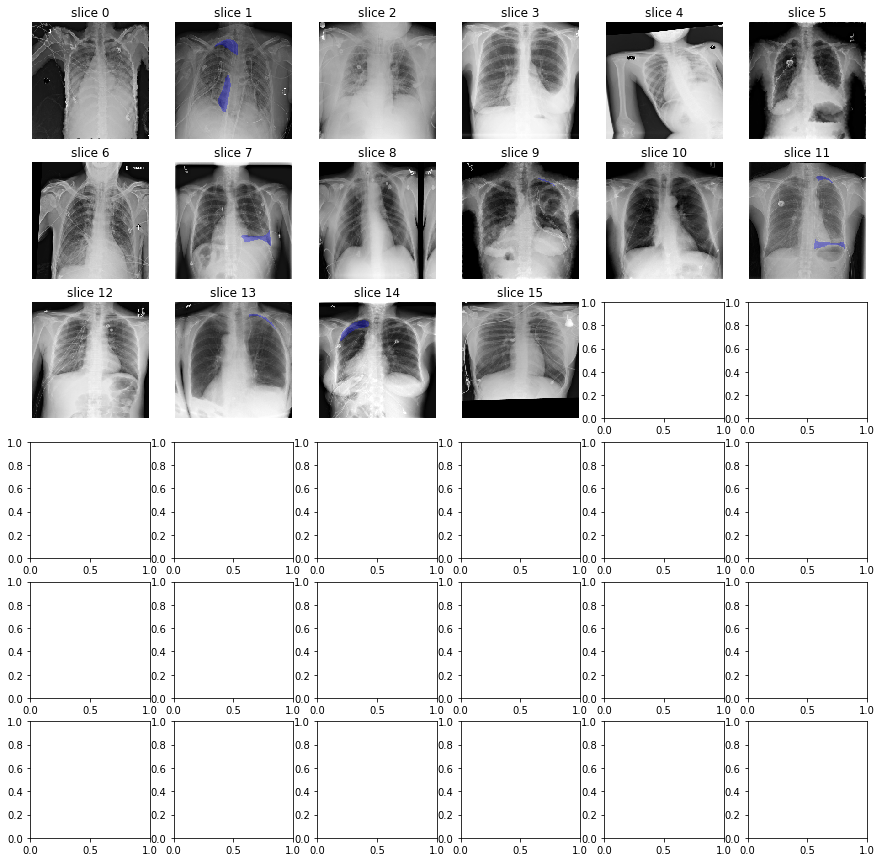

In [4]:
v, m = train_gen.__getitem__(0)
print(v.shape)
print(m.shape)
if img_ch == 3:
    v = v[:, :, :, 0]
# v = np.squeeze(v)
# m = np.argmax(m, axis=-1)
utils.vis_slices(v, m)


In [5]:
model_path = '/data/pneumo_log/val_1//2019_0810_2118/best_weights.hdf5'
# model= models.unet(img_shape=input_shape, out_ch=output_ch, start_ch=16, depth=5) 
# model = models.UEfficientNet(input_shape, dropout_rate=0.5)
custom_objects = {
                'weighted_binary_crossentropy':loss_util.create_weighted_binary_crossentropy(zero_weight, one_weight),
           'dice_coef':loss_util.create_dice_coef(),
           'dice_coef_flat':loss_util.dice_coef_flat,
           'bce_dice_loss':loss_util.bce_dice_loss,
           'dice_loss_flat':loss_util.dice_loss_flat,}

model = load_model(model_path, custom_objects=custom_objects)

# loss = loss_util.create_weighted_binary_crossentropy(zero_weight, one_weight)
loss = loss_util.bce_dice_loss

optimizer = Adam(lr=0.001)
steps_per_epoch = len(train_gen.data_paths) // train_gen.batch_size
validation_steps = len(val_gen.data_paths) // val_gen.batch_size
log_dir = '/data/pneumo_log/' +'val_'+fold+'/'

metrics = [
           loss,
           loss_util.create_weighted_binary_crossentropy(zero_weight, one_weight),
           loss_util.create_dice_coef(),
           loss_util.dice_coef_flat,
           loss_util.bce_dice_loss,
           loss_util.dice_loss_flat,
          ]
epochs = 100


Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.


In [ ]:
train_util.train(model,
             train_gen,
             val_gen,
             optimizer=optimizer,
             loss=loss,
             metrics=metrics,
             lr_mode='cosine',
             validation_steps=validation_steps,
             steps_per_epoch=steps_per_epoch,
             log_dir=log_dir,
             epochs=epochs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 128, 128, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

## See training results

In [ ]:
# laod model
from keras.models import load_model
# model_path = '/data/kits_log/2019_0724_0242/best_weights.hdf5'
model_path = '/data/pneumo_log/val_1//2019_0805_0344/best_weights.hdf5'
custom_objects = {
                'weighted_binary_crossentropy':loss_util.create_weighted_binary_crossentropy(zero_weight, one_weight),
           'dice_coef':loss_util.create_dice_coef(),
           'dice_coef_flat':loss_util.dice_coef_flat,
           'bce_dice_loss':loss_util.bce_dice_loss,
           'dice_loss_flat':loss_util.dice_loss_flat,}
model = load_model(model_path, custom_objects=custom_objects)


In [101]:
images, masks = val_gen.__getitem__(0)
pred = model.predict(images)
index = 10

i = np.squeeze(images[index])
m = np.squeeze(masks[index])
p = np.squeeze(pred[index])
print(np.unique(p))

[9.1127363e-11 1.2514501e-10 1.7214875e-10 ... 3.5596595e-03 3.6568183e-03
 3.6711448e-03]


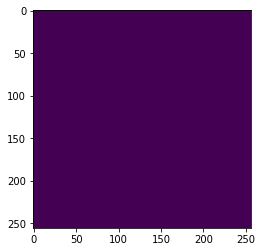

In [102]:
plt.imshow(m)

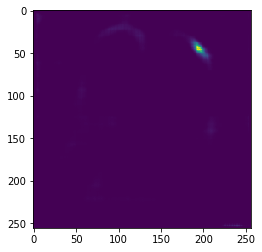

In [103]:
plt.imshow(p)

In [104]:
'/'.join(model_path.split('/')[:-2])

'/data/pneumo_log/val_1/'

In [105]:
m = np.expand_dims(m, axis=0)
p = np.expand_dims(p, axis=0)
m = np.expand_dims(m, axis=-1)
p = np.expand_dims(p, axis=-1)

In [106]:
import keras.backend as K
y_true = K.variable(m)
y_pred = K.variable(p)
# m = np.array(m, dtype=np.float32)
loss_flat = loss_util.dice_coef_flat(y_true, y_pred)
dice_coef = loss_util.create_dice_coef()
dice_value = dice_coef(y_true, y_pred)
loss = loss_util.bce_dice_loss(y_true, y_pred)

In [107]:

K.get_value(loss_flat)

nan

In [108]:
K.get_value(dice_value)

0.60813135

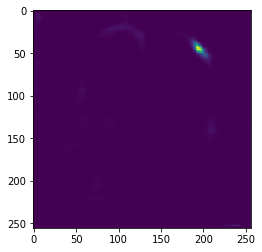

In [109]:
plt.imshow(np.reshape(K.get_value(loss), (256, 256)))

In [110]:
import eval_util

In [115]:
m = np.squeeze(m)
p = np.squeeze(p)
thresh=0.01
eval_util.evaluation(m, p, thresh)

1.0

In [112]:
np.unique(a)

array([1.])

In [99]:
# p = np.where(p>thresh, 1, 0)

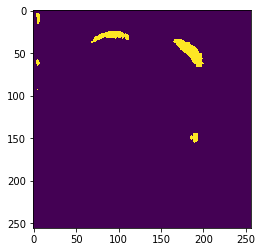

In [83]:
plt.imshow(p)

In [70]:
a = np.greater(p_binary, 0)

In [71]:
a.sum()

61169

In [ ]:
import cv2
cv2.resize(t, (256, 256, 3))